# Predictive Maintenance Tutorial
https://www.unikie.com/en/stories/predictive-maintenance-tutorial-data-scientists/<br>
https://github.com/Unikie/predictive-maintenance-tutorial
predictive algorithm to detect their gadget breakdowns. It is known that the past vibration, pressure and temperature measurements have something to do with the breakdowns.

Data: https://github.com/Unikie/predictive-maintenance-tutorial/tree/master/datasets<br>
Failure: 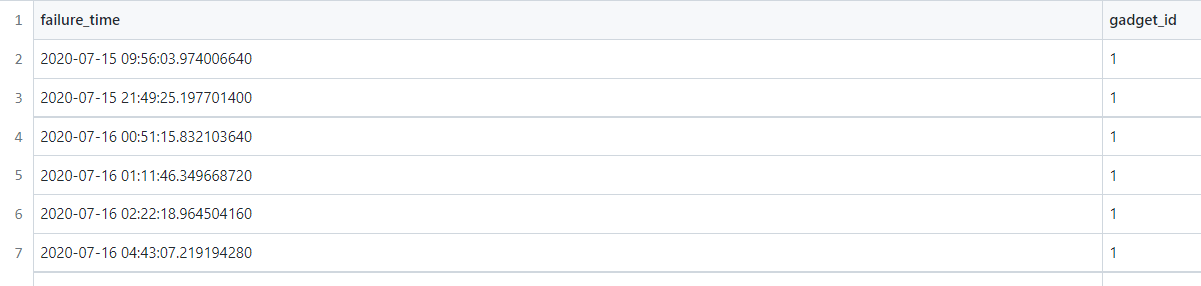
Measurements (no cortan cuando hubo una falla): 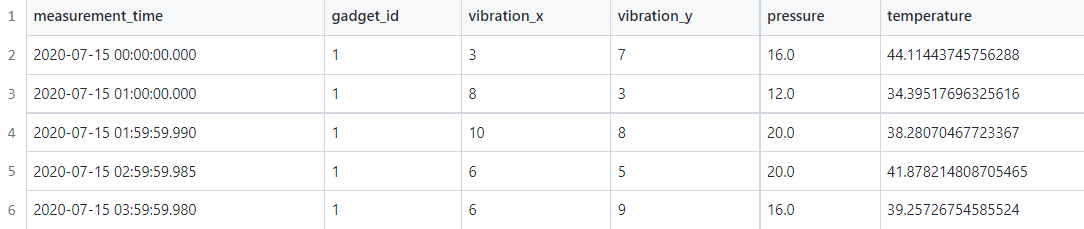


In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler, normalize
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

## 1- Data Import & Transform
Ejecutar antes MP1 - Data Prep.ipynb que deja los datos ya pre-procesados

In [5]:
data_path = 'C:\\Users\\COLMO\\data_mining\\data_pampa'

In [13]:
file = 'EMA_compresores_5min_ok.csv'
csv_measurements = os.path.join(data_path, file)

In [18]:
# 'Bad' = '-1', 'Comm Fail' = '-2', 'I/O Timeout', '-3'
df_measurements = pd.read_csv(csv_measurements, sep=';', parse_dates=['timestamp'])[['timestamp', 'element', 'press_1',
                            'press_2', 'rpm', 'carga_motriz', 'press_suc']]
df_measurements = df_measurements.sort_values(by=['timestamp'], ascending=[True])
df_measurements.tail()

,timestamp,element,press_1,press_2,rpm,carga_motriz,press_suc
118508,2022-01-15 21:50:00,k-03,93.626060,92.599319,1167.803955,91.210938,34.643433
316023,2022-01-15 21:50:00,k-08,-1.000000,-1.000000,1168.435669,92.138672,34.577812
39502,2022-01-15 21:50:00,k-01,92.985725,93.866188,1174.053223,86.865234,34.596718
158011,2022-01-15 21:50:00,k-04,15.990349,35.629791,1157.354248,90.673828,6.647903
355526,2022-01-15 21:50:00,k-09,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000


In [ ]:
file = 

csv_failures = os.path.join(os.getcwd(), 'datasets', 'failures.csv')
df_failures = pd.read_csv(csv_failures, parse_dates=['failure_time'])
df_failures = df_failures.sort_values(by=['failure_time'], ascending=[True])

### MERGE NEXT FAILURE TO MEASUREMENTS
df_combined = pd.merge_asof(
    df_measurements,
    df_failures,
    left_on='measurement_time',
    right_on='failure_time',
    by='gadget_id',
    direction='forward',
)

### TRANSFORM COLUMNS
df_combined['time_to_fail'] = df_combined['failure_time']-df_combined['measurement_time']
df_combined['fail_in_1h'] = np.where(df_combined['time_to_fail']<pd.Timedelta(hours=1), 1, 0)

### CALCULATE RUNNING MEASURES
df_combined = df_combined.reset_index(drop=True)
df_combined = df_combined.sort_values(by=['gadget_id', 'measurement_time'], ascending=[True, True])

df_combined['temperature_6h_std'] = df_combined.groupby('gadget_id')['temperature'].rolling(6).std(ddof=0).reset_index(drop=True)
df_combined['pressure_6h_mean'] = df_combined.groupby('gadget_id')['pressure'].rolling(6).mean().reset_index(drop=True)